In [1]:
# Homework 5 (due 07/30/2024; received an extension due to computer issues)
# Credits:
# Part 1: Sonia Meytin
# Part 2: Kyrylo Bakumenko

# SVM and Kernels

### Objective
Through this project, you will learn to use nonlinear kernels to improve a support vector classifier. The toy examples within this project aim to guide you as you build your intuition for the decision boundaries that can be generated via different kernels.

This project is structured as follows:
#### Part 1: Binary classification of synthetic data
1.1. Generate and explore synthetic data

1.2. SVM with nonlinear kernels
#### Part 2: US Flags
2.1. Load and explore flags data

2.2. SVMs for flag pixel data

2.3. Comparison to decision trees


In [2]:
!unzip flags.zip

Archive:  flags.zip
replace __MACOSX/._flags? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# standard imports
import os, random
import numpy as np
import matplotlib.pyplot as plt

import sklearn.svm as svm

# sklearn imports
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# you may need to install the PIL in your environment
# for installation in mamba environment type "mamba install pillow -c conda-forge" in your miniforge prompt
# for installation in conda environment type "conda install pillow -c conda-forge" in your conda prompt or anaconda prompt
# for installation via pip type "pip install pillow" in your terminal
from PIL import Image

## Part 1: Binary classification of synthetic data

### Part 1.1: Generate and explore synthetic data
The next cell defines the function `generate_dataset`, which you can use to generate synthetic (i.e., computer generated) data sets for binary classification. It includes eight different methods for data-set generation.
1. Try out each method and visualize the resulting data set. For the 'swiss' and 'scurve' data sets, try out two different values of the keyword argument `splits`.
2. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a linear classifier.
3. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a nonlinear classifier.

In [4]:
# Function to convert an array of real numbers into an array of 0s and 1s
def binarize(arr, split=10):
    # Calculate the decile thresholds
    percentiles = int(np.ceil(100/split))
    split_points = np.arange(0, 100+percentiles, percentiles)
    split_points[split_points>100] = 100
    deciles = np.percentile(arr, split_points)

    # Create a new array to hold the modified values
    modified_arr = np.zeros_like(arr)

    # Iterate through each decile range and set values accordingly
    for i in range(split):
        print(i)
        if i == split-1:
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i])] = 1
        else:
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 1

    return modified_arr

# Function to generate datasets
def generate_dataset(dataset_type, n_samples=300, noise=0.1, split=10, random_state=0):
    if dataset_type == 'linearly_separable':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                                   random_state=random_state, n_clusters_per_class=1)
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=[n_samples//2, n_samples//2], random_state=random_state, cluster_std=noise)
    elif dataset_type == 'quantiles':
        X, y = make_gaussian_quantiles(n_samples=n_samples, n_classes=2, cov=noise, random_state=random_state)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
    elif dataset_type == 'unstructured':
        X, y = np.random.random(size=(n_samples, 2)), np.random.randint(0,2, size=(n_samples))
    elif dataset_type == 'swiss':
        X, y = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    elif dataset_type == 'scurve':
        X, y = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    else:
        raise ValueError("Invalid dataset type")

    X = StandardScaler().fit_transform(X)
    return X, y

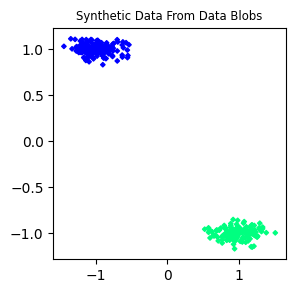

In [5]:
# Generate and visualize data blobs

# Generate the given data using the provided function
xblobs, yblobs = generate_dataset(dataset_type = "blobs", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From Data Blobs", fontsize = "small")
plt.scatter(xblobs[:, 0], xblobs[:, 1], marker = "D", c = yblobs, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively easy to classify with a linear classifier because there are two distinct groups of datapoints, which could very easily be split with a straight line (for example, something like y = x). I anticipate that this dataset would also be relatively easy to classify with a nonlinear classifier because the groups of datapoints are so distinct that a nonlinear curve (for example, a parabola) could also easily and efficiently separate them. If the blobs were closer together, it might make a nonlinear classifier more favorable as the blobs are nonlinear in shape, but they are so far apart in the example plot that it doesn't really matter.

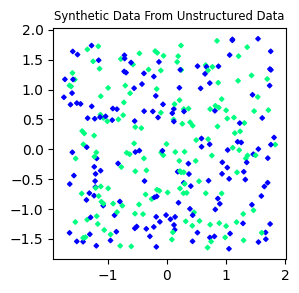

In [6]:
# Generate and visualize unstructured data

# Generate the given data using the provided function
xunstruct, yunstruct = generate_dataset(dataset_type = "unstructured", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From Unstructured Data", fontsize = "small")
plt.scatter(xunstruct[:, 0], xunstruct[:, 1], marker = "D", c = yunstruct, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier because all the different groups are mixed together, so there isn't a clear line which can be drawn between them. I anticipate that this dataset would also be relatively hard to classify with a nonlinear classifier because the plot has neither linear nor nonlinear clustering in it---it is not easily separable at all. If there was at least some clustering by random chance, it might make a nonlinear classifier more favorable as a nonlinear relationship is easier to imagine than a linear one, but the datapoints are so mixed together in the example plot that it doesn't really matter.

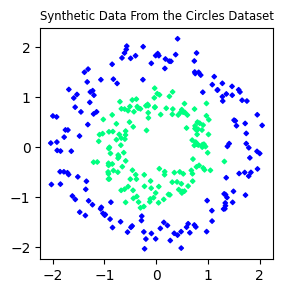

In [7]:
# Generate and visualize circles data set

# Generate the given data using the provided function
xcircles, ycircles = generate_dataset(dataset_type = "circles", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From the Circles Dataset", fontsize = "small")
plt.scatter(xcircles[:, 0], xcircles[:, 1], marker = "D", c = ycircles, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier because the line of separation between the clusters is curved, rather than linear. I anticipate that this dataset would therefore be relatively easy to classify with a nonlinear classifier, as the curved line separating the clusters is nonlinear. If one used an alternative coordinate grid to transform the data into a more linear set of clusters, like polar coordinates, then it might become easier to use a linear classifier, but the dataset's current coordinate system favors a nonlinear classifier.

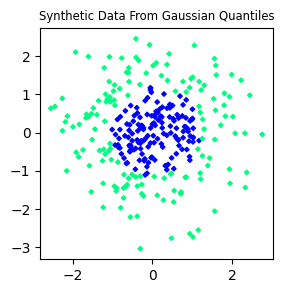

In [8]:
# Generate and visualize Gaussian quantiles

# Generate the given data using the provided function
xquant, yquant = generate_dataset(dataset_type = "quantiles", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From Gaussian Quantiles", fontsize = "small")
plt.scatter(xquant[:, 0], xquant[:, 1], marker = "D", c = yquant, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier because the boundary separating the two clusters is curved rather than linear. I anticipate that this dataset would therefore be relatively easy to classify with a nonlinear classifier, as the curved boundary is nonlinear. Since the two groups are more "touching," unlike the previous example which had a clear space between them, a nonlinear classifier would be slightly harder than in the previous example, but it would still be better than a linear classifier.

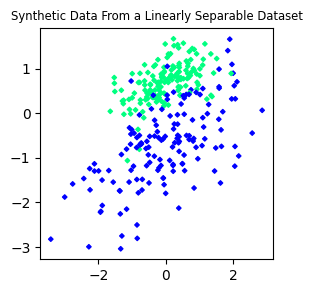

In [9]:
# Generate and visualize linearly separable data

# Generate the given data using the provided function
xlin, ylin = generate_dataset(dataset_type = "linearly_separable", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From a Linearly Separable Dataset", fontsize = "small")
plt.scatter(xlin[:, 0], xlin[:, 1], marker = "D", c = ylin, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively easy to classify with a linear classifier, as it is designed to be linearly separable and the two clusters can be separated fairly well with a straight line (although not exactly). I anticipate that this dataset would also be relatively easy to classify with a nonlinear classifier---while it would definitely be easier to use a linear classifier than a nonlinear classifier, a nonlinear classifier might be able to account for the "overlapping" points or the datapoints on the "wrong" side of the classification line slightly better than a linear classifier would (for example, by using a slightly curved boundary between the two clusters).

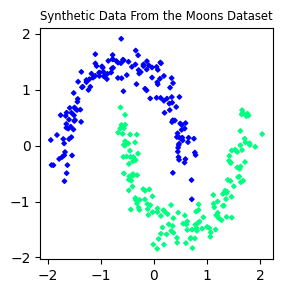

In [10]:
# Generate and visualize moons data set

# Generate the given data using the provided function
xmoons, ymoons = generate_dataset(dataset_type = "moons", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From the Moons Dataset", fontsize = "small")
plt.scatter(xmoons[:, 0], xmoons[:, 1], marker = "D", c = ymoons, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier, as the line between the two clusters is distinctly nonlinear; it looks almost sinusoidal. I anticipate that this dataset would thus be relatively easy to classify with a nonlinear classifier, as the "sinusoidal"-esque boundary between the clusters is nonlinear. While there is no clear straight line to divide the clusters, a non-straight line could easily be imagined to do so.

0
1


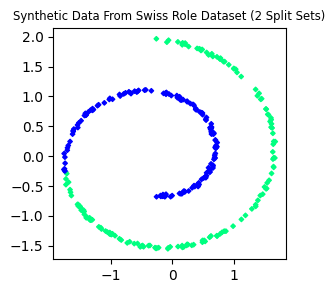

In [11]:
# Generate and visualize swiss role with 2 split sets

# Generate the given data using the provided function
xswiss2, yswiss2 = generate_dataset(dataset_type = "swiss", n_samples = 300, noise = 0.1, split = 2, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From Swiss Role Dataset (2 Split Sets)", fontsize = "small")
plt.scatter(xswiss2[:, 0], xswiss2[:, 1], marker = "D", c = yswiss2, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier, as there is no straight line that can seemingly be drawn through the example plot that would separate the two clusters well. I anticipate that this dataset would be relatively easy to classify with a nonlinear classifier, as there are only two clusters, so a curved line can easily be drawn to separate them fairly well. For example, an oval-shaped boundary could be drawn around the "inner" blue cluster to separate it from the "outer" green cluster.

0
1


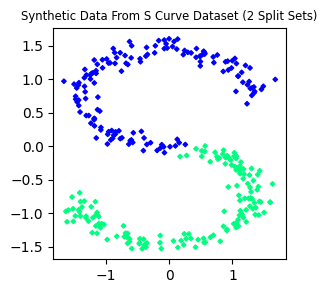

In [12]:
# Generate and visualize S curve with 2 split sets

# Generate the given data using the provided function
xscurve2, yscurve2 = generate_dataset(dataset_type = "scurve", n_samples = 300, noise = 0.1, split = 2, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From S Curve Dataset (2 Split Sets)", fontsize = "small")
plt.scatter(xscurve2[:, 0], xscurve2[:, 1], marker = "D", c = yscurve2, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively easy to classify with a linear classifier, because it is fairly easy to draw a straight line cutting diagonally across the S curve to separate the two clusters fairly well. I anticipate that it would also be relatively easy to classify this dataset with a nonlinear classifier, as one could also draw a curved/nonlinear line through the S curve to separate the two clusters. I think it would be easier to use a nonlinear classifier than a linear classifier, as for a linear classifier the slope of the line would need to be just right (and there still might be a few points on the "wrong" side of the line), but for a nonlinear classifier the line could just curve around the necessary points.

0
1
2
3
4
5
6
7
8
9


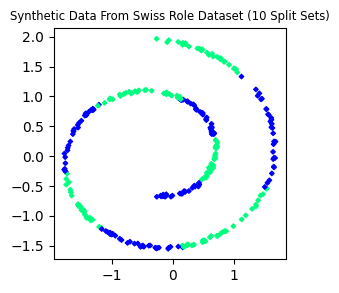

In [13]:
# Generate and visualize swiss role with 10 split sets

# Generate the given data using the provided function
xswiss, yswiss = generate_dataset(dataset_type = "swiss", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From Swiss Role Dataset (10 Split Sets)", fontsize = "small")
plt.scatter(xswiss[:, 0], xswiss[:, 1], marker = "D", c = yswiss, s = 5, cmap = 'winter')

I anticipate that this dataset would be relatively hard to classify with a linear classifier, because there doesn't seem to be any straight line that neatly separates the data. I anticipate that this dataset would be relatively easy to classify with a nonlinear classifier, as any curved line that would separate all blue and green datapoints would be very convoluted (likely a combination of several functions, rather than one simple nonlinear function), but nonetheless, it would be feasible to use a complex nonlinear classifier to separate the two groups as such a curved line could be drawn. Additionally, it would be relatively easy to use a nonlinear classifier if one treated the different blue and green groups as distinct (i.e. several more groups/clusters than two, with multiple clusters of each color). This wouldn't necessarily be the desired effect, but it would still technically be accurate.

0
1
2
3
4
5
6
7
8
9


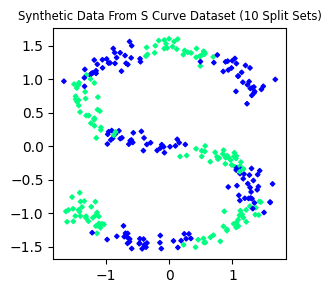

In [14]:
# Generate and visualize S curve with 10 split sets

# Generate the given data using the provided function
xscurve, yscurve = generate_dataset(dataset_type = "scurve", n_samples = 300, noise = 0.1, split = 10, random_state = 0)

# Visualize it prettily
plt.figure(figsize = (3, 3))
plt.title("Synthetic Data From S Curve Dataset (10 Split Sets)", fontsize = "small")
plt.scatter(xscurve[:, 0], xscurve[:, 1], marker = "D", c = yscurve, s = 5, cmap = 'winter')

I anticipate that this dataset would be fairly difficult to classify with a linear classifier, because there doesn't seem to be a straight line that can be drawn through the plot to separate the blue and green datapoints well. I anticipate that it would be relatively easy to classify the data with a nonlinear classifier, as any nonlinear curve that would separate the blue and green points would be fairly complex (a combination of several nonlinear functions, rather than one such simple function), but nonetheless, a curvy line could still feasibly be drawn to separate the two colors/groups, so it is possible to use a complex nonlinear classifier to accomplish this. It would also be possible to separate each cluster on its own like in the previous/swirl example, so that there are multiple clusters/divisions of each color rather than a binary classification system. It wouldn't quite be the desired outcome, but it wouldn't technically be wrong.

### Part 1.2: SVM with nonlinear kernels

The next cell defines the function `kernel_comparison`, which you can use to visually compare the decision boundaries generated by SVMs with different kernels.

1. The kernel comparison currently produces only visual results. Add code to the function so that it also outputs train and test accuracy of the different SVMs. (Note: Think carefully about where the right place in the code is to do a train-test split.)
2. Run the kernel comparison for the data sets from Part 1.1. Do the results confirm or contradict your expectations that you formulated in Part 1.1.? Did any of the results surprise you?
3. Consult sklearn's documentation to learn how the keyword arguments `degree` and `gamma` affect your classifier. Try out a few different values of these parameters. How and what can one infer from the shape of the decision boundary about the classifier's `degree` or `gamma`?

In [15]:
def kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3, suppress_print=False):

    #Define empty arrays for the train and test accuracy, and a filled array for kernel type
    train_accs = []
    test_accs = []
    kernels = ["linear", "poly", "rbf   ", "sigmoid"]
    results_dict = {}

    # Split the data into a training set and a testing set
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

    if if_flag:
        fig, axs = plt.subplots(2, 2, figsize=(5, 5))
        axs = axs.flatten()
    else:
        fig = plt.figure(figsize=(10, 3))

    for ikernel, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # Train the SVC
        clf = svm.SVC(kernel=kernel, degree = deg, gamma = gam).fit(Xtrain, ytrain)

        # Settings for plotting
        if if_flag:
            ax = axs[ikernel]
        else:
            ax = plt.subplot(1, 4, 1 + ikernel)
        #x_min, x_max, y_min, y_max = -3, 3, -3, 3
        #ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        # if if_flag:
        #     x_min, x_max, y_min, y_max = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()
        #     ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # else:
        #     x_min, x_max, y_min, y_max = -3, 3, -3, 3

        # Plot decision boundary and margins
        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )

        if support_vectors:
            # Plot bigger circles around samples that serve as support vectors
            ax.scatter(
                clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150,
                facecolors="none",
                edgecolors="k",
            )

        # Plot samples by color and add legend
        ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
        ax.set_title(kernel)
        ax.axis('off')
        if tight_box:
            ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
            ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

        #Compute accuracy of training data
        train_predictions = clf.predict(Xtrain)
        train_accuracy = accuracy_score(ytrain, train_predictions)*100
        train_acc = str(round(train_accuracy, 2))
        train_accs.append(train_acc)

        #Compute accuracy of testing data
        test_predictions = clf.predict(Xtest)
        test_accuracy = accuracy_score(ytest, test_predictions)*100
        test_acc = str(round(test_accuracy, 2))
        test_accs.append(test_acc)

        # store the results in the dictionary
        results_dict[kernel] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        }

    if not suppress_print:
        print("   kernel\t|  training accuracy\t| testing accuracy")
        print('-----------------------------------------------------------')
        for i in range(0,4):
            # print results to table
            print('    {}\t|      {} \t \t| {}'.format(kernels[i], train_accs[i], test_accs[i]))

    if if_flag:
        return fig, results_dict

    return fig, results_dict

These are the results for the data blobs
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      100.0 	 	| 100.0
    poly	|      100.0 	 	| 100.0
    rbf   	|      100.0 	 	| 100.0
    sigmoid	|      100.0 	 	| 100.0


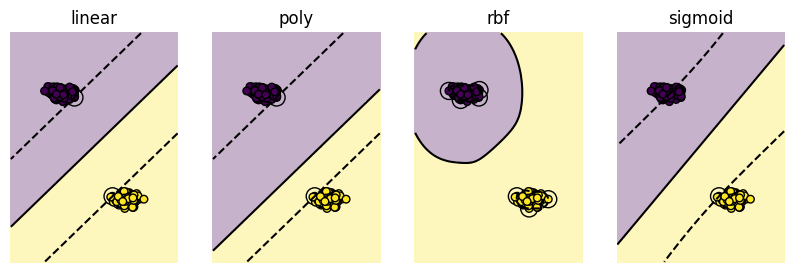

In [16]:
# Show results of kernel comparison for data sets from part 1 - Data Blobs
print("These are the results for the data blobs")
kernel_comparison(xblobs, yblobs, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3);

These are the results for the unstructured data
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      54.17 	 	| 46.67
    poly	|      55.42 	 	| 56.67
    rbf   	|      65.83 	 	| 56.67
    sigmoid	|      55.42 	 	| 45.0


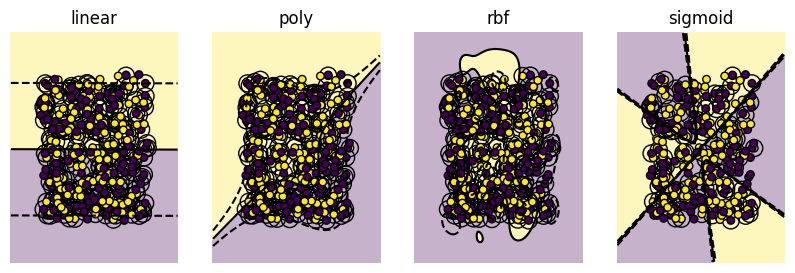

In [17]:
# Show results of kernel comparison for data sets from part 1 - Unstructured Data
print("These are the results for the unstructured data")
kernel_comparison(xunstruct, yunstruct, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3);

These are the results for the circles dataset
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      52.92 	 	| 38.33
    poly	|      72.08 	 	| 51.67
    rbf   	|      100.0 	 	| 100.0
    sigmoid	|      54.17 	 	| 43.33


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '52.92', 'test_accuracy': '38.33'},
  'poly': {'train_accuracy': '72.08', 'test_accuracy': '51.67'},
  'rbf': {'train_accuracy': '100.0', 'test_accuracy': '100.0'},
  'sigmoid': {'train_accuracy': '54.17', 'test_accuracy': '43.33'}})

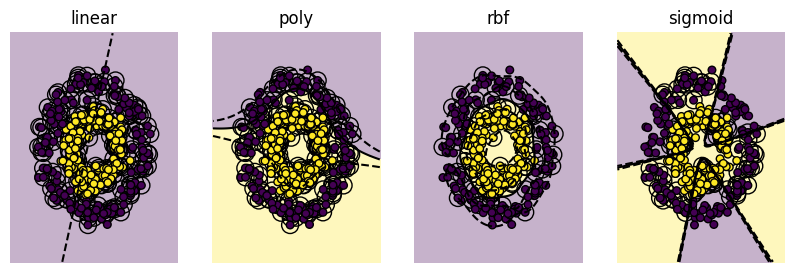

In [18]:
# Show results of kernel comparison for data sets from part 1 - Circles Dataset
print("These are the results for the circles dataset")
kernel_comparison(xcircles, ycircles, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the Gaussian quantiles
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      70.83 	 	| 46.67
    poly	|      62.92 	 	| 40.0
    rbf   	|      98.33 	 	| 96.67
    sigmoid	|      44.17 	 	| 55.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '70.83', 'test_accuracy': '46.67'},
  'poly': {'train_accuracy': '62.92', 'test_accuracy': '40.0'},
  'rbf': {'train_accuracy': '98.33', 'test_accuracy': '96.67'},
  'sigmoid': {'train_accuracy': '44.17', 'test_accuracy': '55.0'}})

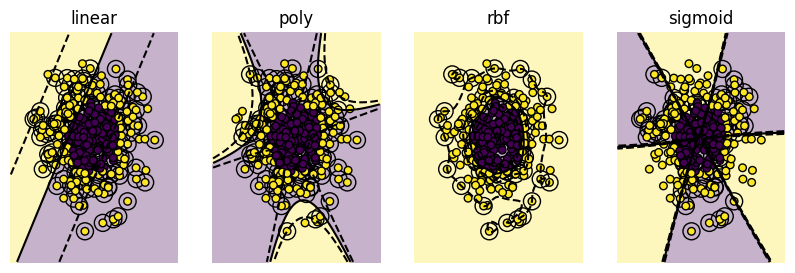

In [19]:
# Show results of kernel comparison for data sets from part 1 - Gaussian Quantiles
print("These are the results for the Gaussian quantiles")
kernel_comparison(xquant, yquant, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the linearly separable dataset
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      92.08 	 	| 91.67
    poly	|      90.42 	 	| 91.67
    rbf   	|      93.75 	 	| 90.0
    sigmoid	|      75.0 	 	| 70.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '92.08', 'test_accuracy': '91.67'},
  'poly': {'train_accuracy': '90.42', 'test_accuracy': '91.67'},
  'rbf': {'train_accuracy': '93.75', 'test_accuracy': '90.0'},
  'sigmoid': {'train_accuracy': '75.0', 'test_accuracy': '70.0'}})

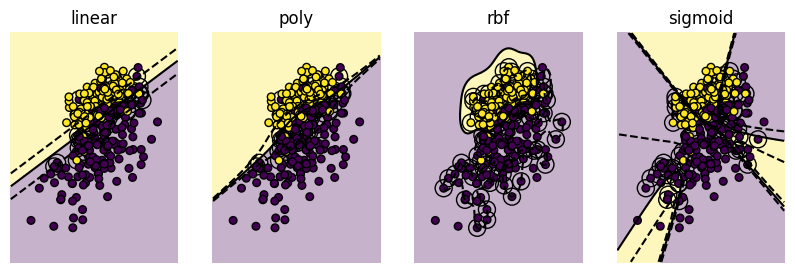

In [20]:
# Show results of kernel comparison for data sets from part 1 - Linearly Separable Dataset
print("These are the results for the linearly separable dataset")
kernel_comparison(xlin, ylin, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the moons dataset
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      86.67 	 	| 90.0
    poly	|      88.75 	 	| 93.33
    rbf   	|      99.58 	 	| 100.0
    sigmoid	|      55.83 	 	| 55.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '86.67', 'test_accuracy': '90.0'},
  'poly': {'train_accuracy': '88.75', 'test_accuracy': '93.33'},
  'rbf': {'train_accuracy': '99.58', 'test_accuracy': '100.0'},
  'sigmoid': {'train_accuracy': '55.83', 'test_accuracy': '55.0'}})

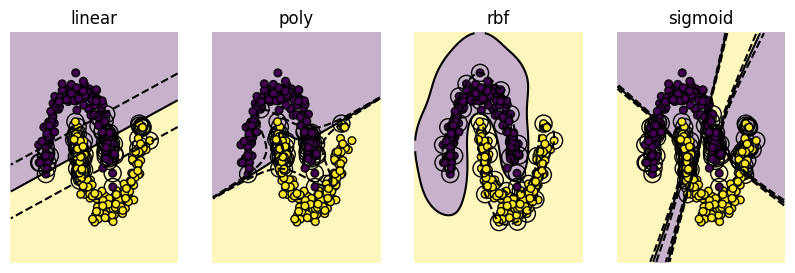

In [21]:
# Show results of kernel comparison for data sets from part 1 - Moons Dataset
print("These are the results for the moons dataset")
kernel_comparison(xmoons, ymoons, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the Swiss role dataset (2 split sets)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      61.67 	 	| 65.0
    poly	|      77.92 	 	| 76.67
    rbf   	|      99.58 	 	| 100.0
    sigmoid	|      42.08 	 	| 50.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '61.67', 'test_accuracy': '65.0'},
  'poly': {'train_accuracy': '77.92', 'test_accuracy': '76.67'},
  'rbf': {'train_accuracy': '99.58', 'test_accuracy': '100.0'},
  'sigmoid': {'train_accuracy': '42.08', 'test_accuracy': '50.0'}})

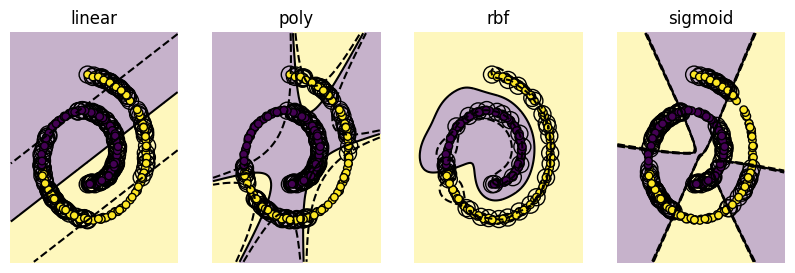

In [22]:
# Show results of kernel comparison for data sets from part 1 - Swiss Role Dataset (2 split sets)
print("These are the results for the Swiss role dataset (2 split sets)")
kernel_comparison(xswiss2, yswiss2, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the s curve dataset (2 split sets)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      100.0 	 	| 100.0
    poly	|      98.75 	 	| 100.0
    rbf   	|      99.58 	 	| 100.0
    sigmoid	|      69.58 	 	| 85.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '100.0', 'test_accuracy': '100.0'},
  'poly': {'train_accuracy': '98.75', 'test_accuracy': '100.0'},
  'rbf': {'train_accuracy': '99.58', 'test_accuracy': '100.0'},
  'sigmoid': {'train_accuracy': '69.58', 'test_accuracy': '85.0'}})

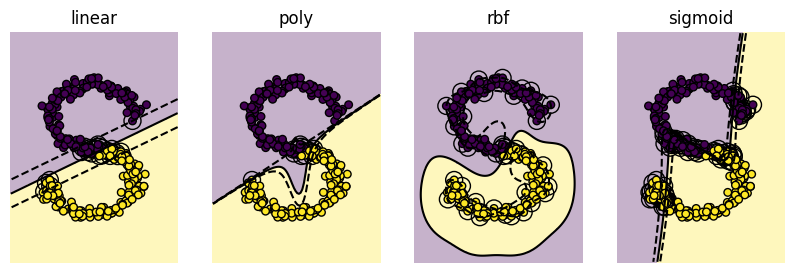

In [23]:
# Show results of kernel comparison for data sets from part 1 - S Curve Dataset (2 split sets)
print("These are the results for the s curve dataset (2 split sets)")
kernel_comparison(xscurve2, yscurve2, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the Swiss role dataset (10 split sets)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      54.17 	 	| 41.67
    poly	|      72.5 	 	| 66.67
    rbf   	|      96.67 	 	| 96.67
    sigmoid	|      32.92 	 	| 30.0


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '54.17', 'test_accuracy': '41.67'},
  'poly': {'train_accuracy': '72.5', 'test_accuracy': '66.67'},
  'rbf': {'train_accuracy': '96.67', 'test_accuracy': '96.67'},
  'sigmoid': {'train_accuracy': '32.92', 'test_accuracy': '30.0'}})

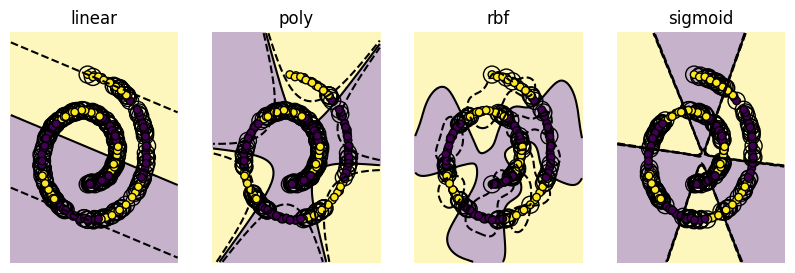

In [24]:
# Show results of kernel comparison for data sets from part 1 - Swiss Role Dataset (10 split sets)
print("These are the results for the Swiss role dataset (10 split sets)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

These are the results for the s curve dataset (10 split sets)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      48.33 	 	| 28.33
    poly	|      77.08 	 	| 81.67
    rbf   	|      94.17 	 	| 86.67
    sigmoid	|      39.58 	 	| 38.33


(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '48.33', 'test_accuracy': '28.33'},
  'poly': {'train_accuracy': '77.08', 'test_accuracy': '81.67'},
  'rbf': {'train_accuracy': '94.17', 'test_accuracy': '86.67'},
  'sigmoid': {'train_accuracy': '39.58', 'test_accuracy': '38.33'}})

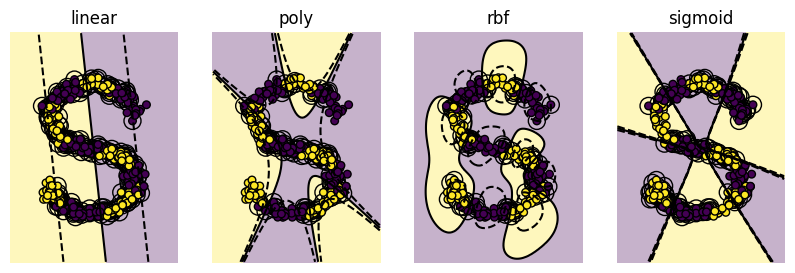

In [25]:
# Show results of kernel comparison for data sets from part 1 - S Curve Dataset (10 split sets)
print("These are the results for the s curve dataset (10 split sets)")
kernel_comparison(xscurve, yscurve, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)

To summarize the results of the kernel comparison (taking the averages of training and testing performance, roughly; no specific values):

Data Blobs: As expected, both the linear and nonlinear kernels performed well. Both linear and nonlinear kernels were fairly easy to use. The blobs were so separate that any kernel could do it. Nothing was surprising.

Unstrucutred Data: As expected, both the linear and nonlinear kernels performed poorly. Both linear and nonlinear kernels were fairly difficult to use. The datapoints were so intermingled that no kernel could do it. Nothing was surprising.

Circles Dataset: As expected, the linear kernel performed worse than the nonlinear kernels. The rbf kernel represented the data best and was easy to use, but the other three kernels were fairly hard to use. It was surprising that the poly kernel performed as poorly as it did, although it did not perform as poorly as the linear kernel.

Gaussian Quantiles: As expected, the linear kernel performed worse than the nonlinear kernels. The rbf kernel represented the data best and was easy to use, but the other three kernels were fairly hard to use. It was somewhat surprising that the linear kernel performed better than some nonlinear kernels on the training data, although it still performed very poorly on the testing data.

Linearly Separable Dataset: As expected, both the linear and nonlinear kernels performed well. The linear kernel represented the data best, and all four kernels were fairly easy to use. It was surprising that the poly kernel was almost as good as the linear kernel---I thought that both linear and nonlinear kernels would perform well, but that there would be a clear benefit to linear over nonlinear.

Moons Dataset: As expected, the linear kernel performed worse than the nonlinear kernels, but all kernels (except for sigmoid) performed fairly well and were fairly easy to use. The rbf kernel represented the data best. It was surprising that the linear kernel performed so well---I thought that it would have more error associated with it.

Swiss Role Dataset, 2 Split Sets: As expected, the linear kernel performed worse than most nonlinear kernels, but all kernels (except for sigmoid) performed fairly well and were fairly easy to use. The rbf kernel represented the data best. It was surprising that the linear kernel performed as well as it did---I thought that it would have more error associated with it.

S Curve Dataset, 2 Split Sets: As expected, both the linear and nonlinear kernels performed relatively well and were all fairly easy to use. The rbf kernel represented the data best. Nothing was surprising.

Swiss Role Dataset, 10 Split Sets: As expected, the linear kernel performed worse than the nonlinear kernels, but all kernels (except for sigmoid) performed fairly well and were fairly easy to use. The rbf kernel represented the data best. It was surprising that the sigmoid kernel performed so poorly---I thought that it would have less error associated with it.

S Curve Dataset, 10 Split Sets: As expected, the linear kernel performed worse than the nonlinear kernels. The linear and sigmoid kernels were fairly hard to use, while the poly and rbf kernels were fairly easy to use. The rbf kernel represented the data best. Nothing was surprising.

Overall, it was surprising to me that the rbf kernel performed best the most frequently, and the sigmoid kernel performed worst most of the time, while the linear and poly kernels had more "middle ground" performance. I expected that the nonlinear kernels would all perform roughly equally well.

These are the results for standard degree (3)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      54.17 	 	| 41.67
    poly	|      72.5 	 	| 66.67
    rbf   	|      96.67 	 	| 96.67
    sigmoid	|      32.92 	 	| 30.0
These are the results for lowered degree (1)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      54.17 	 	| 41.67
    poly	|      53.75 	 	| 41.67
    rbf   	|      96.67 	 	| 96.67
    sigmoid	|      32.92 	 	| 30.0
These are the results for increased degree (5)
   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      54.17 	 	| 41.67
    poly	|      73.33 	 	| 66.67
    rbf   	|      96.67 	 	| 96.67
    sigmoid	|      32.92 	 	| 30.0
These are the results for standard gamma (3)
   kernel	|  training accuracy	| testing accuracy
------------------------

(<Figure size 1000x300 with 4 Axes>,
 {'linear': {'train_accuracy': '54.17', 'test_accuracy': '41.67'},
  'poly': {'train_accuracy': '72.5', 'test_accuracy': '66.67'},
  'rbf': {'train_accuracy': '96.25', 'test_accuracy': '98.33'},
  'sigmoid': {'train_accuracy': '32.5', 'test_accuracy': '28.33'}})

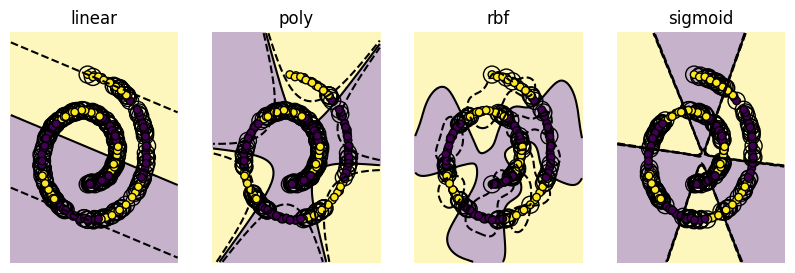

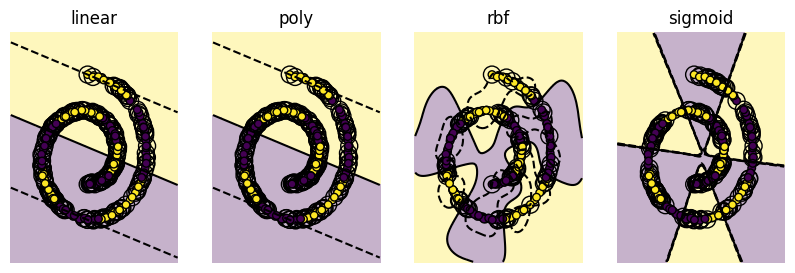

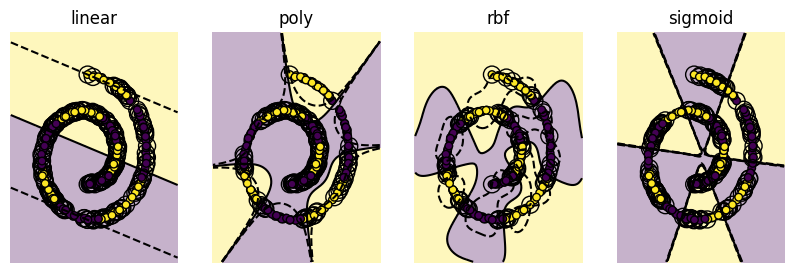

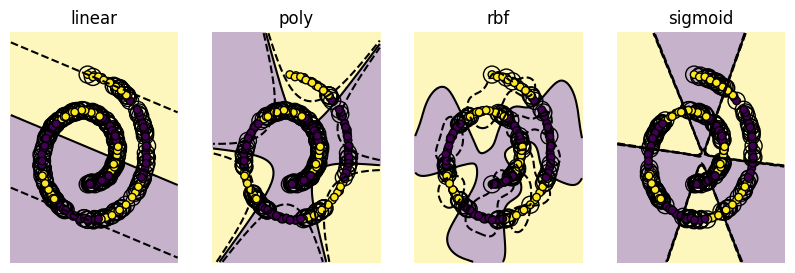

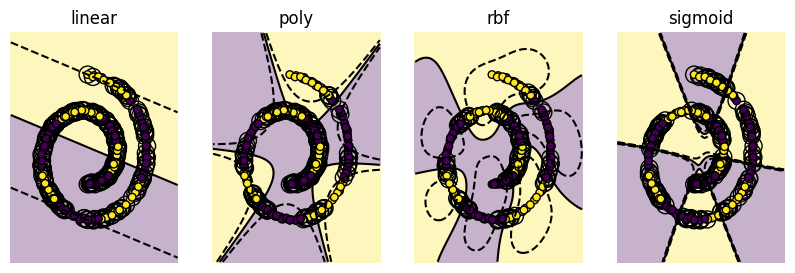

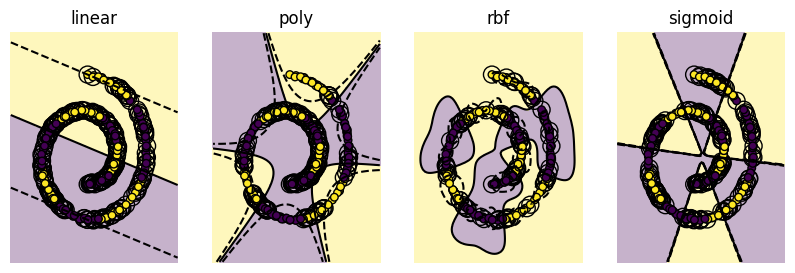

In [26]:
# Examine effect of degree and gamma keyword
# For the sake of conssitency, I will use the Swiss Role Dataset (10 split sets) do display the effects of degree and gamma here.
# However, similar effects can be seen in all the different data generation methods.

# First, we will examine the effect of standard degree (3), lowered degree (1), and increased degree (5), with constant standard gamma (3)
print("These are the results for standard degree (3)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)
print("These are the results for lowered degree (1)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 1, gam = 3)
print("These are the results for increased degree (5)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 5, gam = 3)

# Then, we will examine the effect of standard gamma (3), lowered gamma (1), and increased gamma (5), with constant standard degree (3)
print("These are the results for standard gamma (3)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 3)
print("These are the results for lowered gamma (1)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 1)
print("These are the results for increased gamma (5)")
kernel_comparison(xswiss, yswiss, support_vectors=True, tight_box=False, if_flag=False, deg = 3, gam = 5)

The `degree` argument affects the polynomial kernel function. It changes the model by adjusting the degree of the polynomial kernel that is fit to the data. This affects the model's bias-variance tradeoff by decreasing bias and increasing variance as the degree of the polynomial is increased.

As one increases the `degree`, the decision boundary becomes more accurate. Higher order polynomials generally represent the data better. This could potentially lead to overfitting down the line.

The `gamma` argument affects the rbf, poly, and sigmoid kernel functions, but most prominently affects rbf. It changes the model by adjusting the degree to which each sample affects the decision boundary. This affects the model's bias-variance tradeoff by decreasing bias and increasing variance as the value of gamma is increased.

As one increases `gamma`, the decision boundary becomes more "accurate" as it takes each sample into account more and more. This quickly leads to overfitting as the decision boundary becomes "wobbly,"  reflecting that it considers individual datapoints so much that it begins to miss trends in the data. Thus, the model would become less and less accurate if overfitting became an issue.

Notably, these effects can't really be seen in the above examples. This is because when I increased the gamma or degree values too much (enough to make the effect visible), my computer would crash. Thus, a fairly wide range of gamma and degree values is acceptable before overfitting becomes a problem, and any changes in bias and variance are fairly small and incremental, so they can be fine-tuned to fit a given dataset without too much concern.

## Part 2: US Flags

### Part 2.1: Load and explore flags data
The function `load_images` loads the image data from the flags folder and turns each image into a binary (i.e., black and white) array.

1. Load the flags data.
2. Display four flags of your choice in a figure. Use the `matplotlib` commands `subplot` and `imshow` to create a figure with 2x2 flags. Consult the `matplotlib` documentation to find a way set the aspect ratio of your displayed flags to match their original aspect ratio. Update your code accordingly.

In [27]:
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert image to black and white
            img = np.array(img)//(256/2) # Convert to BW
            images.append(img)
            labels.append(filename.split('.')[0])  # Extract the state code as label
    return images, labels

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


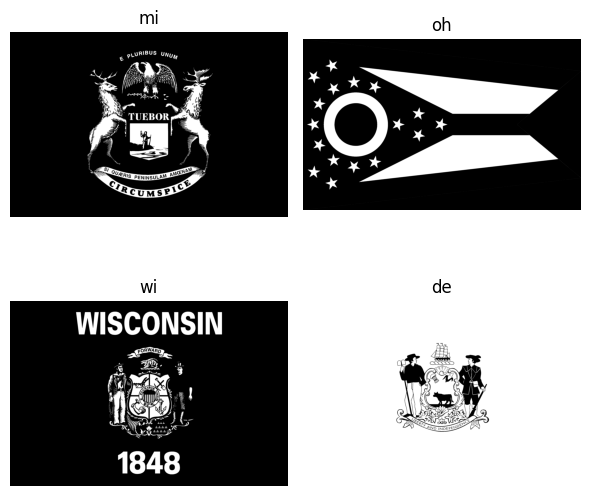

In [28]:
# Display four black-and-white flags in a 2x2 grid

# load
images, labels = load_images('flags')

selected_images = images[:4]
selected_labels = labels[:4]

# display
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis('off')
    ax.set_aspect('equal') # aspect ratio to match original
plt.tight_layout()
plt.show()

### Part 2.2: SVMs for flag pixel data
The function `sample_pixels` samples a pixel from a given image uniformly at random.

1. Use the `sample_pixels`  function to generate synthetic data sets of pixels from for a flag image.
2. Update the `kernel_comparison` function so that if `if_flag` is `True` the decision boundaries are plotted in a 2x2 grid of subplots with plot ranges matching the height and width of the flags.
3. Show the results of the kernel comparison for the four flags that your previously selected. Use the highest values of `degree` and `gamma` that still run *reasonably fast* on your laptop.

4. Adjust your code so that you can run the quantitative part (i.e., the calculation of train and test accuracy) without plotting the decision boundaries. Run the adjusted code on all flags to indentify for each kernel the flags that yield to best easiest-to-classify and hardest-to-classify data sets. Test how the number of of pixels sampled affects your results.

In [29]:
def sample_pixels(image, num_samples=100):
    pixel_data = []
    pixel_labels = []
    height, width = image.shape
    for _ in range(num_samples):
        x1 = random.randint(0, width - 1)
        x2 = random.randint(0, height - 1)
        pixel_data.append([x1/width-0.5, x2/width-0.5])
        pixel_labels.append(image[x2,x1])
    return np.array(pixel_data), np.array(pixel_labels, dtype=int)

   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      90.0 	 	| 95.0
    poly	|      90.0 	 	| 95.0
    rbf   	|      90.0 	 	| 95.0
    sigmoid	|      90.0 	 	| 95.0


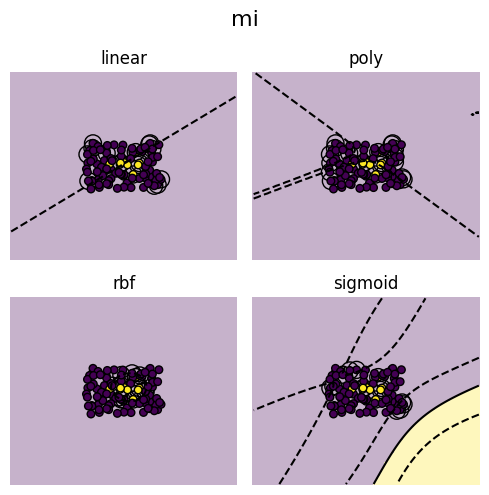

   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      67.5 	 	| 90.0
    poly	|      67.5 	 	| 90.0
    rbf   	|      67.5 	 	| 90.0
    sigmoid	|      67.5 	 	| 90.0


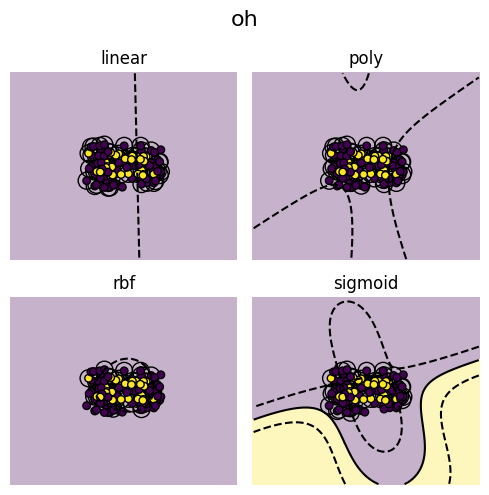

   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      90.0 	 	| 90.0
    poly	|      90.0 	 	| 90.0
    rbf   	|      90.0 	 	| 90.0
    sigmoid	|      90.0 	 	| 90.0


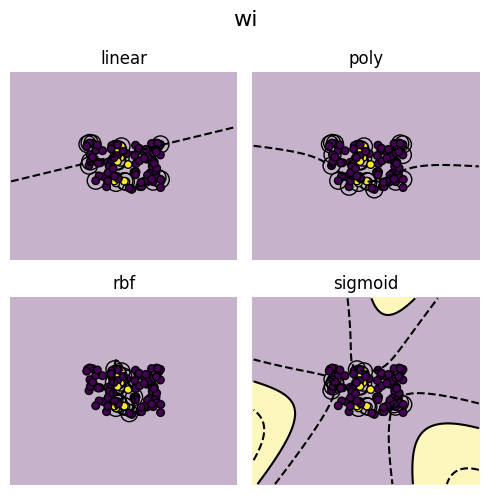

   kernel	|  training accuracy	| testing accuracy
-----------------------------------------------------------
    linear	|      97.5 	 	| 100.0
    poly	|      97.5 	 	| 100.0
    rbf   	|      97.5 	 	| 100.0
    sigmoid	|      97.5 	 	| 100.0


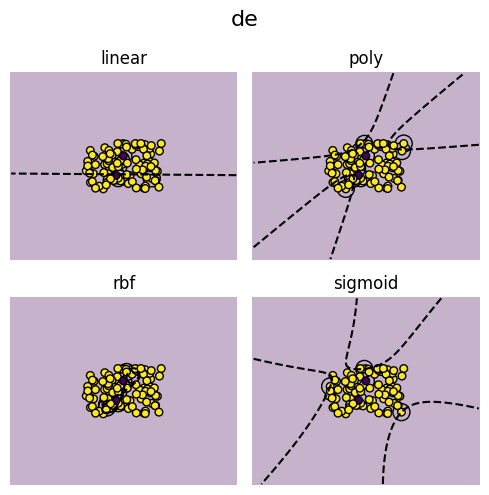

In [30]:
# Visual kernel comparison for selected flags
for i, label in enumerate(selected_labels):
    X, y = sample_pixels(images[i])
    fig, kernel_results = kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=True, deg=3, gam=3)
    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    plt.show()

In [31]:
# Non-visual kernel comparison for all flags

# Method to compare results of all kernels for given gamma and degree
def compare_all_kernels(images, labels, gamma, degree):
    overall_results = {}

    for i, label in enumerate(labels):
        X, y = sample_pixels(images[i], num_samples=500)
        fig, kernel_results = kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=True, deg=degree, gam=gamma, suppress_print=True)
        plt.close(fig)
        overall_results[label] = kernel_results

    # aggregate results
    aggregated_results = {'linear': {'train_accuracy': [], 'test_accuracy': []},
                          'poly': {'train_accuracy': [], 'test_accuracy': []},
                          'rbf': {'train_accuracy': [], 'test_accuracy': []},
                          'sigmoid': {'train_accuracy': [], 'test_accuracy': []}}

    for label, kernels in overall_results.items():
        for kernel, results in kernels.items():
            aggregated_results[kernel]['train_accuracy'].append(float(results['train_accuracy']))
            aggregated_results[kernel]['test_accuracy'].append(float(results['test_accuracy']))

    mean_results = {}
    for kernel, results in aggregated_results.items():
        mean_train_acc = np.mean(results['train_accuracy'])
        mean_test_acc = np.mean(results['test_accuracy'])
        mean_results[kernel] = {'mean_train_accuracy': round(mean_train_acc, 2), 'mean_test_accuracy': round(mean_test_acc, 2)}

    return overall_results, mean_results

In [32]:
def compare_kernels_by_sample_size(images, labels, gamma, degree, sample_sizes):
    results = []

    for sample_size in tqdm(sample_sizes, desc="Sample Sizes"):
        for image, label in zip(images, labels):
            X, y = sample_pixels(image, num_samples=sample_size)
            if len(np.unique(y)) < 2:
                continue  # skip if there are not enough classes (?)
            fig, kernel_results = kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=True, deg=degree, gam=gamma, suppress_print=True)
            plt.close(fig)

            for kernel in kernel_results:
                results.append({
                    'flag': label,
                    'sample_size': sample_size,
                    'kernel': kernel,
                    'train_accuracy': float(kernel_results[kernel]['train_accuracy']),
                    'test_accuracy': float(kernel_results[kernel]['test_accuracy'])
                })

    return pd.DataFrame(results)


Attempt to visualize spread of num_samples and effect on accuracy/stability of predictions

Sample Sizes: 100%|██████████| 11/11 [06:24<00:00, 34.95s/it]


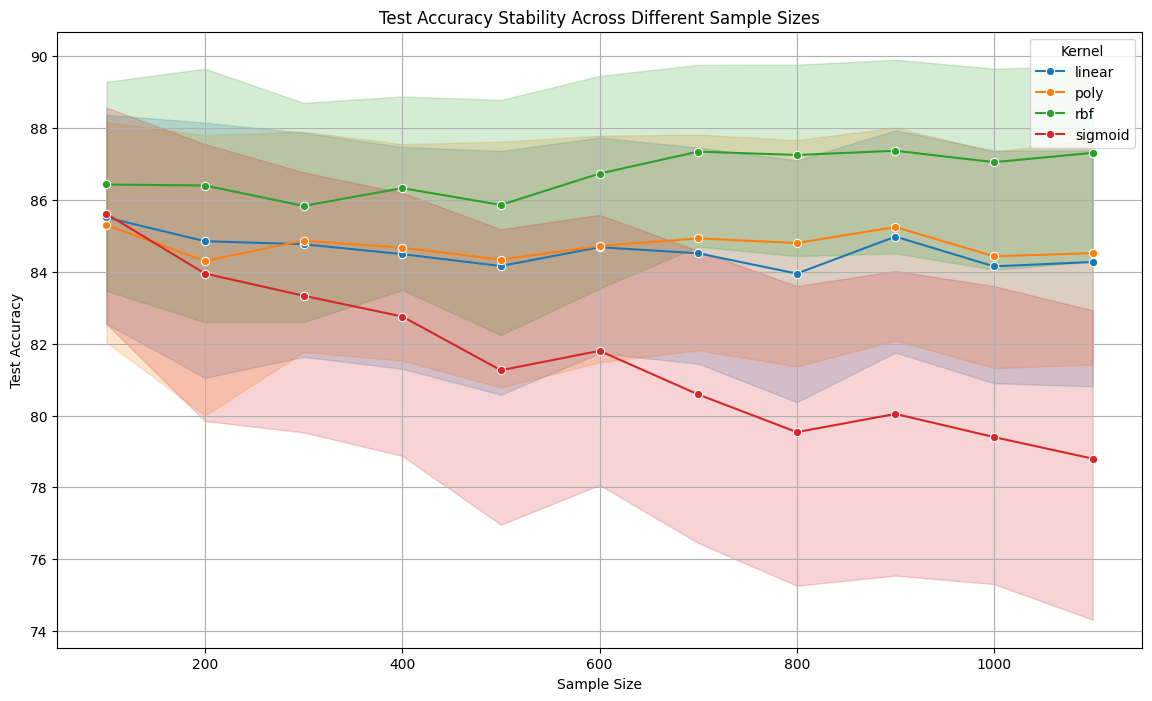

In [33]:
def plot_accuracy_stability(df_results):
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_results, x='sample_size', y='test_accuracy', hue='kernel', marker='o')
    plt.title('Test Accuracy Stability Across Different Sample Sizes')
    plt.xlabel('Sample Size')
    plt.ylabel('Test Accuracy')
    plt.legend(title='Kernel')
    plt.grid(True)
    plt.show()

gamma = 3
degree = 3
sample_sizes = range(100, 1200, 100)

df_results = compare_kernels_by_sample_size(images, labels, gamma, degree, sample_sizes)
plot_accuracy_stability(df_results)


In [34]:
def run_kernel_comparison(X, y, degree=3, gamma=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # dict to keep track of accuracy
    results = {}

    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        # train the SVC
        clf = svm.SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X_train, y_train)

        # compute train and test accuracy
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        results[kernel] = [train_accuracy, test_accuracy]

    return results

In [35]:
def all_flags_kernel_comparison(images, labels, num_samples=500):
    results = {
        'flag': labels,
        'linear_train': [], 'linear_test': [],
        'poly_train': [], 'poly_test': [],
        'rbf_train': [], 'rbf_test': [],
        'sigmoid_train': [], 'sigmoid_test': []
    }

    for image, label in zip(images, labels):
        flag_X, flag_y = sample_pixels(image, num_samples=num_samples)
        flag_dict = run_kernel_comparison(flag_X, flag_y)

        results['linear_train'].append(flag_dict['linear'][0])
        results['linear_test'].append(flag_dict['linear'][1])
        results['poly_train'].append(flag_dict['poly'][0])
        results['poly_test'].append(flag_dict['poly'][1])
        results['rbf_train'].append(flag_dict['rbf'][0])
        results['rbf_test'].append(flag_dict['rbf'][1])
        results['sigmoid_train'].append(flag_dict['sigmoid'][0])
        results['sigmoid_test'].append(flag_dict['sigmoid'][1])

    df_results = pd.DataFrame(results)
    return df_results

In [36]:
def flag_kernel_results(df_results, sort_column):
    df_sorted = df_results.sort_values(by=sort_column, ascending=False)

    # top 3 and bottom 3 labels and values
    top_3 = df_sorted.head(3)
    bottom_3 = df_sorted.tail(3)

    print(f'Top 3 flags by {sort_column} accuracy:')
    print(top_3[['flag', sort_column]])

    print(f'\nBottom 3 flags by {sort_column} accuracy:')
    print(bottom_3[['flag', sort_column]])

df_results = all_flags_kernel_comparison(images, labels, num_samples=500)

In [37]:
# analyze results for each kernel
print('\n-----------------------------------------\n')
for kernel in ['linear_test', 'poly_test', 'rbf_test', 'sigmoid_test']:
    flag_kernel_results(df_results, kernel)
    print('\n-----------------------------------------\n')


-----------------------------------------

Top 3 flags by linear_test accuracy:
   flag  linear_test
28   ak     1.000000
42   nm     0.986667
40   ri     0.980000

Bottom 3 flags by linear_test accuracy:
   flag  linear_test
24   fl     0.593333
4    ia     0.560000
39   md     0.526667

-----------------------------------------

Top 3 flags by poly_test accuracy:
   flag  poly_test
28   ak   1.000000
42   nm   0.986667
40   ri   0.980000

Bottom 3 flags by poly_test accuracy:
   flag  poly_test
16   hi   0.626667
24   fl   0.600000
39   md   0.600000

-----------------------------------------

Top 3 flags by rbf_test accuracy:
   flag  rbf_test
28   ak  1.000000
42   nm  0.986667
40   ri  0.980000

Bottom 3 flags by rbf_test accuracy:
   flag  rbf_test
24   fl  0.633333
16   hi  0.626667
39   md  0.600000

-----------------------------------------

Top 3 flags by sigmoid_test accuracy:
   flag  sigmoid_test
28   ak      1.000000
42   nm      0.986667
40   ri      0.980000

Bottom 3 

For these experiments, I set `num_samples` to [ADD NUMBER HERE] because the results of the experiments seem to be the most stable for this number of sampled pixels.

The linear kernel performed best (i.e., highest test accuracy) on the flags of the following three states:

[ALASKA, RHODE ISLAND, NEVADA]

It performed worst on the flags of the following three states:

[ALABAMA, IOWA, MARYLAND]

The polynomial kernel performed best on the flags of the following three states:

[ALASKA, RHODE ISLAND, NEVADA]

It performed worst on the flags of the following three states:

[WEST VIRGINIA, ALABAMA, MARYLAND]

The radial-basis function kernel performed best on the flags of the following three states:

[ALASKA, RHODE ISLAND, NEVADA]

It performed worst on the flags of the following three states:

[FLORIDA, ALABAMA, MARYLAND]

The sigmoid kernel performed best on the flags of the following three states:

[ALASKA, RHODE ISLAND, NEVADA]

It performed worst on the flags of the following three states:

[MARYLAND, ALABAMA, IOWA]

### Part 2.3: Comparison to decision trees
Decision trees and SVMs yield substantially different decision boundaries.

1. An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set. Explain why.

2. For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy as well. Explain why.

3. Select four flags for which you anticipate a *simple* decision tree to outperform all your SVMs. Write code that fits a decision tree to a flag pixel data set. Use your code to check your hypothesis.

An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set, because it can create as many splits as necessary to ensure each leaf node contains only one or very few data points, thus perfectly classifying every instance in the training set..

For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy because the size and diversity of the dataset allow the model to learn general patterns and relationships since the size of the dataset is enough to represent the fundamental patterns and relationships, making it more robust and capable of generalizing well to new, unseen data.

A simple decision tree is likely to perform well on the sampled pixel data of the flags of [COLORODO, ALABAMA, TEXAS, HAWAII].

In [39]:
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate

# cecision tree comparison function
def decision_tree(X, y, max_depth=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dt_clf = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    dt_train_acc = accuracy_score(y_train, dt_clf.predict(X_train))
    dt_test_acc = accuracy_score(y_test, dt_clf.predict(X_test))
    return {'dt': [dt_train_acc, dt_test_acc]}

# SVM comparison
def run_kernel_comparison(X, y, degree=3, gamma='scale'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = {}

    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        clf = SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X_train, y_train)
        train_accuracy = accuracy_score(y_train, clf.predict(X_train))
        test_accuracy = accuracy_score(y_test, clf.predict(X_test))
        results[kernel] = [train_accuracy, test_accuracy]

    return results

# extends the existing function to include decision tree results
def all_flags_kernel_comparison_with_dt(images, labels, num_samples=500):
    results = {
        'flag': labels,
        'linear_train': [], 'linear_test': [],
        'poly_train': [], 'poly_test': [],
        'rbf_train': [], 'rbf_test': [],
        'sigmoid_train': [], 'sigmoid_test': [],
        'dt_train': [], 'dt_test': []
    }

    for image, label in zip(images, labels):
        flag_X, flag_y = sample_pixels(image, num_samples=num_samples)
        flag_dict = run_kernel_comparison(flag_X, flag_y)
        dt_dict = decision_tree(flag_X, flag_y)

        results['linear_train'].append(flag_dict['linear'][0])
        results['linear_test'].append(flag_dict['linear'][1])
        results['poly_train'].append(flag_dict['poly'][0])
        results['poly_test'].append(flag_dict['poly'][1])
        results['rbf_train'].append(flag_dict['rbf'][0])
        results['rbf_test'].append(flag_dict['rbf'][1])
        results['sigmoid_train'].append(flag_dict['sigmoid'][0])
        results['sigmoid_test'].append(flag_dict['sigmoid'][1])
        results['dt_train'].append(dt_dict['dt'][0])
        results['dt_test'].append(dt_dict['dt'][1])

    df_results = pd.DataFrame(results)
    # rounds to 3 decimal places
    df_results = df_results.round(3)
    return df_results

# find the best SVM fit score and type
def find_best_svm_fit(row):
    best_score = max(row['linear_test'], row['poly_test'], row['rbf_test'], row['sigmoid_test'])
    if best_score == row['linear_test']:
        best_type = 'linear'
    elif best_score == row['poly_test']:
        best_type = 'poly'
    elif best_score == row['rbf_test']:
        best_type = 'rbf'
    else:
        best_type = 'sigmoid'
    return best_type, best_score

def calculate_percentage_increase(dt_score, svm_score):
    return ((dt_score - svm_score) / svm_score) * 100

def filter_and_sort_df_by_percentage_increase(df_results):
    increases = []
    for index, row in df_results.iterrows():
        best_type, best_score = find_best_svm_fit(row)
        percentage_increase = calculate_percentage_increase(row['dt_test'], best_score)
        increases.append(percentage_increase)

    df_results['percentage_increase'] = increases
    sorted_df = df_results.sort_values(by='percentage_increase', ascending=False)
    return sorted_df

df_results = all_flags_kernel_comparison_with_dt(images, labels, num_samples=500)
best_dt_df = df_results.sort_values(by='dt_test', ascending=False).head(10)
sorted_df_by_increase = filter_and_sort_df_by_percentage_increase(df_results).head(10)

print("Top 10 Flags with Best Decision Tree Test Accuracy:")
print(best_dt_df)

print("\nTop 10 Flags with Greatest Percentage Increase in Accuracy from SVM to Decision Tree:")
print(sorted_df_by_increase)

# Prettier output using tabulate
def pretty_print_comparison(df, title):
    headers = ["Flag", "Decision Tree Test Accuracy", "Best SVM Kernel", "Best SVM Test Accuracy", "Percentage Increase"]
    table = []
    for index, row in df.iterrows():
        best_type, best_score = find_best_svm_fit(row)
        percentage_increase = calculate_percentage_increase(row['dt_test'], best_score)
        table.append([row['flag'], row['dt_test'], best_type, best_score, f"{percentage_increase:.2f}%"])
    print(title)
    print(tabulate(table, headers=headers, tablefmt='pretty', showindex=False))

pretty_print_comparison(best_dt_df, "Top 10 Best Decision Tree Results:")
pretty_print_comparison(sorted_df_by_increase, "Top 10 Greatest Percentage Increases in Accuracy from SVM to Decision Tree:")


Top 10 Flags with Best Decision Tree Test Accuracy:
   flag  linear_train  linear_test  poly_train  poly_test  rbf_train  \
40   ri         0.971        0.980       0.971      0.980      0.971   
34   tx         0.857        0.853       0.889      0.913      0.951   
37   nv         0.980        0.993       0.980      0.993      0.980   
28   ak         0.991        0.980       0.991      0.980      0.991   
11   pa         0.931        0.967       0.931      0.967      0.931   
30   ar         0.794        0.807       0.794      0.807      0.897   
29   vt         0.954        0.927       0.954      0.927      0.954   
36   co         0.726        0.767       0.763      0.820      0.926   
22   tn         0.940        0.947       0.940      0.947      0.940   
2    wi         0.914        0.940       0.914      0.940      0.914   

    rbf_test  sigmoid_train  sigmoid_test  dt_train  dt_test  
40     0.980          0.971         0.980     0.997    0.993  
34     0.960          0.669  

I chose the flags of

Alabama: simple design with a red cross on a white background, with distinct separation between the red and white regions making it easier for a decision tree to create partitions.

Colorodo: simple geometric design with a red "C" and blue, white, and gold stripes. clear color boundaries and geometric patterns that can be partition effectively.

Texas: simple design of a single star, horizontal stripes, distinct color regions and clear separations.

Hawaii: Large amount of straight stripes.

In general, I was looking simple features that can be partitioned, especially lines/stripes.

Indeed
* Hawaii: 0.94
* Colorodo: 0.96
* Texas: 0.987

Are among the most effective to classify, and with large margins over the SVM as well.


As for the other two flags,

In [40]:
df_results[df_results['flag'] == 'al']

,flag,linear_train,linear_test,poly_train,poly_test,rbf_train,rbf_test,sigmoid_train,sigmoid_test,dt_train,dt_test,percentage_increase
45,al,0.646,0.573,0.646,0.573,0.754,0.7,0.457,0.407,0.714,0.647,-7.571429


I was, however, surpised to see that alabama and texas were not as effectively classified, despite having stripes and simple shapes. In alabama's case, perhaps it is the diagonality of the stripes.